# DL2Vec

In [1]:
import sys
sys.path.append("../../../")

import torch as th
#import logging


import pickle as pkl
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
import mowl
mowl.init_jvm("10g")
from mowl.datasets.ppi_yeast import PPIYeastSlimDataset
from mowl.model import EmbeddingModel
from mowl.projection.dl2vec.model import DL2VecProjector
from mowl.projection.factory import projector_factory
from mowl.walking.factory import walking_factory
import mowl.evaluation.base as ev
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/zhapacfp/Github/mowl/mowl/lib/slf4j-log4j12-1.7.3.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/zhapacfp/Github/mowl/mowl/lib/slf4j-simple-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]


## DL2Vec

In [8]:
dataset = PPIYeastSlimDataset()
projector = projector_factory("dl2vec", bidirectional_taxonomy = True)
edges = projector.project(dataset.ontology)

walker = walking_factory(
        "node2vec", 
        alpha = 0.1, 
        walk_length = 20, 
        num_walks = 10, 
        outfile = "data/walks")
walker.walk(edges)

corpus = LineSentence("data/walks")

w2v_model = Word2Vec(
        corpus,
        sg=1,
        min_count=1,
        vector_size=10,
        window = 5,
        epochs = 2,
        workers = 16)


vectors = w2v_model.wv

w2v_model.save('data/dl2vec') 

INFO: Number of ontology classes: 11020
Starting pool...+ started preprocessing probabilities...
Thread 0, nodes to process 6198
* processing nodes is over
Thread 0, edges to process 249179
- finished preprocessing probabilities  after 14 seconds
* processing edges is over
+ started processing 0


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 127856 words, keeping 10647 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 253650 words, keeping 11030 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 381340 words, keeping 11030 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 508644 words, keeping 11030 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 636684 words, keeping 11030 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 761238 words, keeping 11030 word types


- finished processing 0 after 5267
* processing is over, shutting down the executor


INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 887572 words, keeping 11030 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 1017066 words, keeping 11030 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #90000, processed 1144614 words, keeping 11030 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #100000, processed 1271458 words, keeping 11030 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #110000, processed 1398496 words, keeping 11030 word types
INFO:gensim.models.word2vec:collected 11030 word types from a corpus of 1400796 raw words and 110200 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 11030 unique words (100.0%% of original 11030, drops 0)', 'datetime': '2022-05-14T23:33:11.328253', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) \n[GCC 9.4.0]',

In [4]:

#model.train()

## Evaluation

In [9]:
from mowl.projection.edge import Edge
dataset = PPIYeastSlimDataset()
vectors = Word2Vec.load("data/dl2vec").wv

eval_projector = projector_factory('taxonomy_rels', taxonomy=False, relations=["http://interacts_with"])

training_set = eval_projector.project(dataset.ontology)
testing_set = eval_projector.project(dataset.testing)

training_entities,_ = Edge.getEntitiesAndRelations(training_set)
testing_entities,_ = Edge.getEntitiesAndRelations(testing_set)

entities = list(set(training_entities) | set(testing_entities))


INFO:gensim.utils:loading Word2Vec object from data/dl2vec
INFO:gensim.utils:loading wv recursively from data/dl2vec.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'data/dl2vec', 'datetime': '2022-05-14T23:33:27.133959', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-109-generic-x86_64-with-glibc2.27', 'event': 'loaded'}


INFO: Number of ontology classes: 11020
INFO: Number of ontology classes: 3610


In [10]:
from mowl.evaluation.rank_based import EmbeddingsRankBasedEvaluator
from mowl.evaluation.base import CosineSimilarity
evaluator = EmbeddingsRankBasedEvaluator(
        vectors, 
        testing_set, 
        CosineSimilarity, 
        training_set = training_set, 
        head_entities = entities,
        device = "cuda"
)

evaluator.evaluate(show=True)

INFO:root:Tail entities not input. It will be assumed that tail entities are the same as head entities.
INFO:root:Entity http://4932.YNL150W not present in the embeddings dictionary. Ignoring it.
INFO:root:Entity http://4932.YNL150W not present in the embeddings dictionary. Ignoring it.
INFO:root:Training scores created
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12040/12040 [01:08<00:00, 174.77it/s]

Hits@1:   0.00 Filtered:   0.00
Hits@10:  0.01 Filtered:   0.04
Hits@100: 0.23 Filtered:   0.32
MR:       892.11 Filtered: 846.13
AUC:      0.85 Filtered:   0.86
Evaluation finished. Access the results using the "metrics" attribute.


In [3]:
from mowl.embeddings.graph_based.dl2vec.model import DL2Vec
dataset = PPIYeastSlimDataset()



model = DL2Vec(dataset, 
               "data/dl2vectoolkit", 
               bidirectional_taxonomy = True,
                alpha = 0.1, 
            walk_length = 20, 
            num_walks = 10, 

               workers = 16, 
               wv_epochs=2,
                vector_size=10,
        window = 5,
               device = "cuda"
              )
model.train()

INFO:root:Generating graph from ontology...


INFO: Number of ontology classes: 11020


INFO:root:Finished graph generation
INFO:root:Generating random walks...


Starting pool...+ started processing 9
+ started processing 8
+ started processing 1
+ started processing 2
+ started processing 3
+ started processing 5
+ started processing 7
+ started processing 6
+ started processing 4
+ started processing 0


INFO:root:Walks generated
INFO:root:Starting to train the Word2Vec model
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 52092 words, keeping 7056 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 105116 words, keeping 8568 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 156821 words, keeping 9327 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 209620 words, keeping 9826 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 259104 words, keeping 10189 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 312565 words, keeping 10438 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 365025 words, keeping 10636 word types
INFO:gensim.models.word

- finished processing 1 after 294
- finished processing 6 after 294
- finished processing 2 after 295
- finished processing 3 after 297
- finished processing 4 after 297
- finished processing 7 after 301
- finished processing 8 after 301
- finished processing 9 after 301
- finished processing 0 after 304
- finished processing 5 after 305
* processing is over, shutting down the executor


INFO:gensim.models.word2vec:PROGRESS: at sentence #100000, processed 520650 words, keeping 10986 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #110000, processed 572074 words, keeping 11020 word types
INFO:gensim.models.word2vec:collected 11020 word types from a corpus of 572994 raw words and 110200 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 11020 unique words (100.0%% of original 11020, drops 0)', 'datetime': '2022-05-11T17:42:56.079551', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-109-generic-x86_64-with-glibc2.27', 'event': 'prepare_vocab'}
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 572994 word corpus (100.0%% of original 572994, drops 0)', 'datetime': '2022-05-11T17:42:56.080316', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda

In [4]:
from mowl.evaluation.rank_based import ModelRankBasedEvaluator
from mowl.evaluation.base import  CosineSimilarity

In [5]:
evaluator = ModelRankBasedEvaluator(model, device = "cuda" )

INFO:gensim.utils:loading Word2Vec object from data/dl2vectoolkit
INFO:gensim.utils:loading wv recursively from data/dl2vectoolkit.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'data/dl2vectoolkit', 'datetime': '2022-05-11T17:42:57.772433', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-109-generic-x86_64-with-glibc2.27', 'event': 'loaded'}


INFO: Number of ontology classes: 11020
INFO: Number of ontology classes: 3610


INFO:root:Entity http://4932.YNL150W not present in the embeddings dictionary. Ignoring it.
INFO:root:Entity http://4932.YNL150W not present in the embeddings dictionary. Ignoring it.
INFO:root:Training scores created


In [6]:
evaluator.evaluate()

  0%|                                                                                                                                                          | 0/12040 [00:00<?, ?it/s]/home/zhapacfp/Github/mowl/mowl/examples/DL2Vec/../../../mowl/embeddings/graph_based/dl2vec/model.py:171: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  method = CosineSimilarity(th.tensor(list(self.embeddings.values()))).to(self.device)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12040/12040 [03:44<00:00, 53.57it/s]

Evaluation finished. Access the results using the "metrics" attribute.


In [7]:
evaluator.metrics

{'hits_1': 0.0010799136069114472,
 'hits_10': 0.021681342415683667,
 'hits_100': 0.2258680843994019,
 'mean_rank': 909.2116215318159,
 'rank_auc': 0.8474046536652964,
 'fhits_1': 0.008223957468017943,
 'fhits_10': 0.09827213822894168,
 'fhits_100': 0.371739491609902,
 'fmean_rank': 853.3638478152517,
 'frank_auc': 0.8567849619501862}

In [ ]:
Hits@1:   0.00 Filtered:   0.01
Hits@10:  0.02 Filtered:   0.10
Hits@100: 0.23 Filtered:   0.37
MR:       909.21 Filtered: 853.36
AUC:      0.85 Filtered:   0.86
Evaluation finished. Access the results using the "metrics" attribute.

In [14]:
evaluator.metrics

{'hits_1': 0.0005814919421830869,
 'hits_10': 0.009470011629838843,
 'hits_100': 0.09719222462203024,
 'mean_rank': 1586.1243977404883,
 'rank_auc': 0.7337503412437721,
 'fhits_1': 0.0005814919421830869,
 'fhits_10': 0.014786509386941352,
 'fhits_100': 0.13116796810101347,
 'fmean_rank': 1531.2406130586476,
 'frank_auc': 0.7429675151273696}

## TSNE

In [11]:
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)
            ec_numbers[f"http://{prot_id}"] = it[4].split(".")[0]

In [12]:
from mowl.visualization.base import TSNE as MTSNE

tsne = MTSNE(vectors, ec_numbers, entities = entities)
tsne.generate_points(5000, workers = 16, verbose = 1)


INFO:root:Found 11030 embedding vectors. Processing only 1693.
/home/zhapacfp/anaconda3/envs/mowldev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/mowldev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1693 samples in 0.001s...
[t-SNE] Computed neighbors for 1693 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1693
[t-SNE] Computed conditional probabilities for sample 1693 / 1693
[t-SNE] Mean sigma: 0.174506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.354324
[t-SNE] KL divergence after 5000 iterations: 0.993385


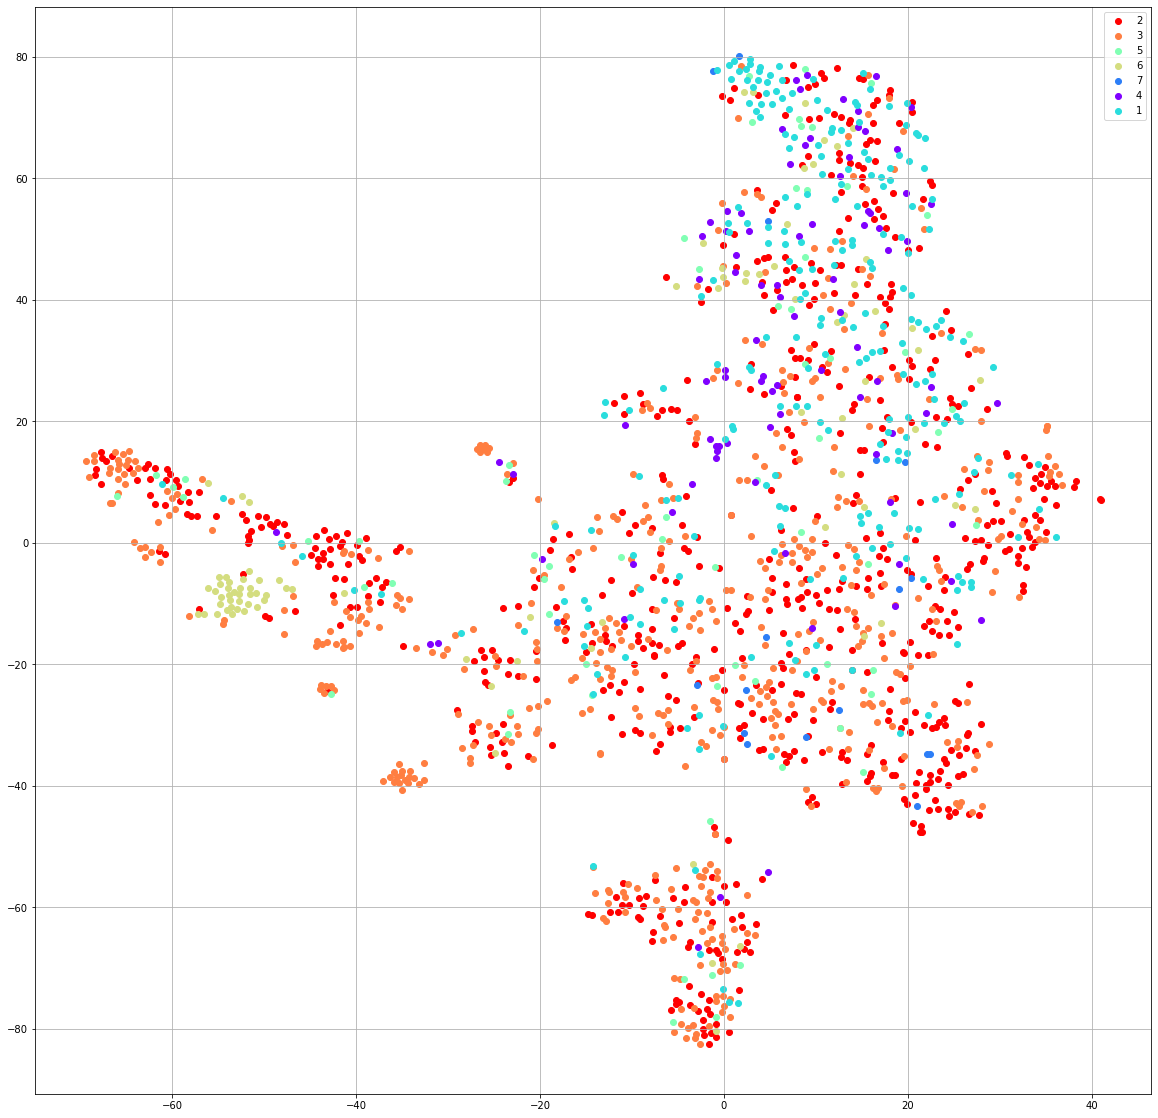

In [13]:
tsne.show()

In [11]:

tsne.savefig('data/mowl_tsne.jpg')